In [ ]:
!pip install split-folders tqdm
!pip install pillow
from PIL import Image
import PIL

import tensorflow as tf
import numpy as np
from keras.preprocessing import image
import split_folders 
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from shutil import rmtree
from skimage import data, exposure, img_as_float

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2


from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
if not (os.path.isdir('/content/drive/My Drive/Colab Notebooks/rockpaperscissors/rockpaperscissors/rps-cv-images')):
  !wget https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip -O '/content/drive/My Drive/Colab Notebooks/rockpaperscissors.zip'

In [ ]:
if not (os.path.isdir('/content/drive/My Drive/Colab Notebooks/rockpaperscissors/rockpaperscissors/rps-cv-images')):
  !unzip '/content/drive/My Drive/Colab Notebooks/rockpaperscissors.zip' -d '/content/drive/My Drive/Colab Notebooks/rockpaperscissors'

In [ ]:
# Coba untuk copy satu citra untuk dilakukan proses augmentasi

parent_dir="/content/drive/My Drive/Colab Notebooks/rockpaperscissors/rockpaperscissors/aug_test/"
directory_aug="coba"
path=os.path.join(parent_dir, directory_aug)
if (os.path.isdir(path)):
  rmtree(path)
if not (os.path.isdir(path)):
  os.makedirs(path)
  copyfile("/content/drive/My Drive/Colab Notebooks/rockpaperscissors/rockpaperscissors/rps-cv-images/paper"+"/"+"04l5I8TqdzF9WDMJ.png",path+"/"+"coba.png")


Sebelum dilakukan adjustment: 


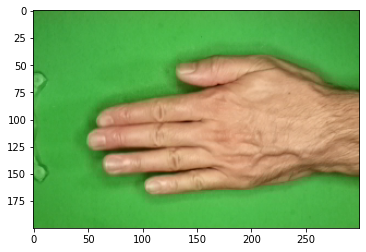

Found 1 images belonging to 1 classes.
Setelah dilakukan adjustment: 


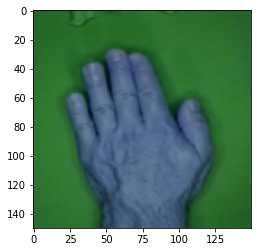

Untuk selanjutnya adjustment tersebut digunakan untuk proses training data.


In [ ]:
## Blok pemrograman untuk proses mengaugmentasi data
# Bagian image yang belum di-adjust

print("Sebelum dilakukan adjustment: ")
aug_folder=path+"/coba.png"
im = Image.open(aug_folder)  
plt.imshow(im)
plt.show()

def pengaturan_kecerahan_hsv(img):
    # Mengubah gambar menjadi HSV 
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Proses pencerahan secara random
    ratio = .5 + np.random.uniform()
    # Lakukan terlebih dulu proses konversi ke int32 
    # agar tidak terjadi uint8 overflow karena range tipe data terbatas.
    # lakukan perkalian nilai HSV pada channel [2] dengan rasio kecerahan 
    # diatas. Kemudian, klip (potong) nilai dari 0 hingga 255
    # yang selanjutnya dilakukan proses penggantian tipe data kembali ke 
    # uint8.
    hsv[:,:,2] =  np.clip(hsv[:,:,2].astype(np.int32) * ratio, 0, 255).astype(np.uint8)
    # Mengembalikan HSV ke space warna BGR
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

# Lakukan trial dan error untuk mendapatkan hasil yang optimal
augmentation_generate = ImageDataGenerator(
    rescale=1./255,        
    horizontal_flip= False,
    rotation_range=90,
    vertical_flip = False,
    validation_split = 0.0, preprocessing_function=pengaturan_kecerahan_hsv
)

data_train_generator = augmentation_generate.flow_from_directory(
    parent_dir,
    target_size = (150,150), # Besar gambar
    batch_size=5, # Besar data yang dipropagasikan
    class_mode = 'categorical', # folder-folder terpisah sebagai kategori (rock, paper, scissor)
    subset = 'training',
    shuffle=True
)

x_batch, y_batch = next(data_train_generator)

print("Setelah dilakukan adjustment: ")
for i in range (0,1):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()
print("Untuk selanjutnya adjustment tersebut digunakan untuk proses training data.")



Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


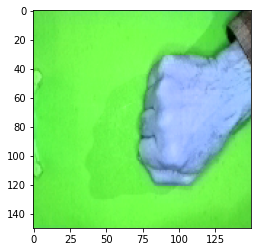

In [ ]:
folder_data="/content/drive/My Drive/Colab Notebooks/rockpaperscissors/rockpaperscissors/rps-cv-images"



# Data Augmentation berguna untuk menghindari overfitting
# src: https://www.tensorflow.org/tutorials/images/data_augmentation


augmentation_generate = ImageDataGenerator(
    
    rescale = 1./255, # rescaling untuk mengurangi beban komputasi
    horizontal_flip = False, # tidak melakukan proses flipping
    vertical_flip = False,  # tidak melakukan proses flipping
    validation_split = 0.4, # Sesuai dengan ketentuan Dicoding 
    preprocessing_function=pengaturan_kecerahan_hsv
)  

# Berguna 
# https://keras.io/api/preprocessing/image/#flowfromdirectory-method
data_train_generator = augmentation_generate.flow_from_directory(
    folder_data,  # data yang digunakan sebagai input
    target_size = (150,150), # besar pixel data output
    batch_size=5,   # 5 data untuk proses propagasi maju
    class_mode = 'categorical', # folder-folder terpisah sebagai kategori (rock, paper, scissor)
    subset = 'training', # Penanda training data
    #shuffle=True
)

data_validation_gen = augmentation_generate.flow_from_directory(
    folder_data,          # data yang digunakan sebagai input
    target_size=(150,150), # besar pixel data output
    batch_size=5,           # 5 data untuk proses propagasi maju
    class_mode='categorical', # folder-folder terpisah sebagai kategori (rock, paper, scissor)
    #shuffle=False,
    subset = 'validation'     # Penanda validasi yang terpisah dari proses training.
)

#Proses untuk menampilkan satu buah sampel data yang digunakan dalam proses training
x_batch, y_batch = next(data_train_generator)

for i in range (0,1):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()

In [ ]:
class Callback_Accuracy(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97):
      print("\n")
      print("Proses Training data dihentikan karena akurasi telah melebihi 97%")
      self.model.stop_training = True
callback_accuracy=Callback_Accuracy()

In [ ]:
model_cnn3 = Sequential()
shape=(150, 150, 3)
model_cnn3.add(Conv2D(32, kernel_size=(4, 4), activation='relu', input_shape=shape))
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Conv2D(64, kernel_size=(4, 4), activation='relu'))
model_cnn3.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn3.add(Conv2D(128, kernel_size=(4, 4), activation='relu'))
model_cnn3.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn3.add(Conv2D(256, kernel_size=(4, 4), activation='relu')) # melakukan konvolusi dengan keluaran 256 buah dengan kernel size (size konvolusi) 4x4
model_cnn3.add(MaxPooling2D(pool_size=(2, 2)))    # mencari nilai max untuk pool size matrix 2x2
model_cnn3.add(Flatten())                         # flatten array
model_cnn3.add(Dense(256, activation='relu'))     # Fungsi aktivasi relu berjumlah 256 buah
model_cnn3.add(Dense(3, activation='softmax'))    # Fungsi aktivasi softmax untuk 3 buah output (paper, rock, scissor)

In [ ]:
loss_fn = tf.keras.losses.Poisson(reduction="auto", name="poisson")   # Loss function berbentuk fungsi Poisson digunakan untuk menghitung nilai error
model_cnn3.compile(loss=loss_fn, optimizer=tf.optimizers.Adam(), metrics=['accuracy']) # optimizer digunakan untuk update nilai hidden layer untuk updating nilai ke nilai yang lebih baik

In [ ]:
# Menurut https://androidkt.com/how-to-set-steps-per-epoch-validation-steps-and-validation-split-in-kerass-fit-method/
# step_per_epoch digunakan untuk mendefinisikan berapa banyak batch per sampel 
# yang digunakan pada satu epoch. (digunakan untuk mendeclare bahwa satu epoch
# finish)
model_cnn3.fit(
      data_train_generator, # Data train generator
      epochs=40,           # Jumlah epoch maksimal
      steps_per_epoch=65,  # Jumlah data yang diperlukan untuk menyelesaikan satu kali epoch
      validation_steps=5,  # Jumlah data validasi yang dilewatkan
      validation_data=data_validation_gen, verbose=1, callbacks=[callback_accuracy])

Epoch 1/40
65/65 [==============================] - 23s 359ms/step - loss: 0.6996 - accuracy: 0.4031 - val_loss: 0.6303 - val_accuracy: 0.4800
Epoch 2/40
65/65 [==============================] - 23s 356ms/step - loss: 0.5236 - accuracy: 0.7723 - val_loss: 0.4291 - val_accuracy: 0.9200
Epoch 3/40
65/65 [==============================] - 23s 357ms/step - loss: 0.4168 - accuracy: 0.9136 - val_loss: 0.3968 - val_accuracy: 0.9200
Epoch 4/40
65/65 [==============================] - 23s 357ms/step - loss: 0.4106 - accuracy: 0.9231 - val_loss: 0.3501 - val_accuracy: 1.0000
Epoch 5/40
65/65 [==============================] - 23s 357ms/step - loss: 0.3985 - accuracy: 0.9414 - val_loss: 0.3928 - val_accuracy: 0.9200
Epoch 6/40
65/65 [==============================] - 23s 353ms/step - loss: 0.4129 - accuracy: 0.9354 - val_loss: 0.4974 - val_accuracy: 0.8000
Epoch 7/40
65/65 [==============================] - 23s 357ms/step - loss: 0.4023 - accuracy: 0.9292 - val_loss: 0.3738 - val_accuracy: 0.9600

Saving 1VRzspyXpQ6A2rKy.png to 1VRzspyXpQ6A2rKy.png
1.0
Gunting!


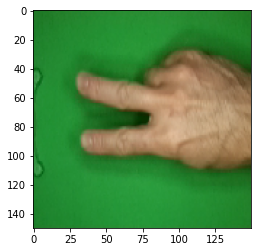

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image


uploaded = files.upload()

for uk in uploaded.keys():

  lokasi = uk 
  img = image.load_img(lokasi, target_size =(150 , 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model_cnn3.predict(images, batch_size=10)

  if classes[0,0]!=0:
    print(classes[0,0])
    print('Kertas!')
  elif classes[0,1]!=0:
    print(classes[0,1])
    print('Batu!')
  else:
    print(classes[0,2])
    print('Gunting!')